# Однослойный перцептрон

В этом блокноте мы рассмотрим построение однослойного перцептрона с нуля, при помощи `numpy`. Сначала загрузим требуемые для дальнейшего библиотеки.





In [ ]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import numpy as np
from keras.datasets import mnist

Посмотрим на наш набор данных. Перед нами черно-белые изображения рукописных цифр размера $8 \times 8$ пикселей. 
Данные, которые мы будем использовать -- это строки длины $64$ -- распрямленные матрицы размера $8 \times 8$, в ячейках которых указывается интенсивность соответсвующего пикселя. Интенсивность измеряется в диапазоне $0-16$.

In [ ]:
mnist_dataset = datasets.load_digits()
mnist_dataset

{'data': array([[ 0.,  0.,  5., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ..., 10.,  0.,  0.],
        [ 0.,  0.,  0., ..., 16.,  9.,  0.],
        ...,
        [ 0.,  0.,  1., ...,  6.,  0.,  0.],
        [ 0.,  0.,  2., ..., 12.,  0.,  0.],
        [ 0.,  0., 10., ..., 12.,  1.,  0.]]),
 'target': array([0, 1, 2, ..., 8, 9, 8]),
 'frame': None,
 'feature_names': ['pixel_0_0',
  'pixel_0_1',
  'pixel_0_2',
  'pixel_0_3',
  'pixel_0_4',
  'pixel_0_5',
  'pixel_0_6',
  'pixel_0_7',
  'pixel_1_0',
  'pixel_1_1',
  'pixel_1_2',
  'pixel_1_3',
  'pixel_1_4',
  'pixel_1_5',
  'pixel_1_6',
  'pixel_1_7',
  'pixel_2_0',
  'pixel_2_1',
  'pixel_2_2',
  'pixel_2_3',
  'pixel_2_4',
  'pixel_2_5',
  'pixel_2_6',
  'pixel_2_7',
  'pixel_3_0',
  'pixel_3_1',
  'pixel_3_2',
  'pixel_3_3',
  'pixel_3_4',
  'pixel_3_5',
  'pixel_3_6',
  'pixel_3_7',
  'pixel_4_0',
  'pixel_4_1',
  'pixel_4_2',
  'pixel_4_3',
  'pixel_4_4',
  'pixel_4_5',
  'pixel_4_6',
  'pixel_4_7',
  'pixel_5_0',
  'pixel_5_1',
 

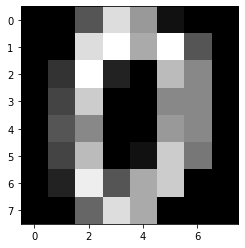

In [ ]:
plt.imshow(mnist_dataset.images[0], cmap=plt.cm.gray)

Нам понадобится $10$ нейронов и, как обсуждалось в лекции, $65$ весов для каждого нейрона.

Начнем с описания функции потерь и обозначений, используемых в дальнейшем, а затем подробно разберем написанный код.

Итак, **исходный набор** данных будем обозначать $X$ — это матрица размера $[n \times p]$, где $n$ — количество тренировочных данных, $p$ — количество входов (у нас на данный момент 65), первый столбец матрицы $X$ будем считать состоящим из $-1$ (напомню — для сдвигов). 

**Матрица весов** $W$ имеет размер $[p \times m]$, где $m$ — это количество классов (в нашем случае их будет $10$). 

Пусть также
$$
x_i = (x_{i}^0, x_i^1, ..., x_i^{p}), \quad x_i^0 = -1, \quad i \in \{1, 2, ..., n\},
$$
— $i$-ый тренировочный объект, $y_i$ — числовая метка класса $i$-ого объекта,
$$
w^j = (w_0^j, w_1^j, ..., w_{p}^j)^T, \quad j \in \{1, 2, ..., m\},
$$
— веса $j$-ого нейрона — столбцы матрицы $W$, 

Напишем интересующую нас функцию потерь, $y = \{y_1, ..., y_n\}$:
$$
Loss(X, W, y) = -\frac{1}{n} \sum\limits_{i = 1}^n \ln \frac{\exp(x_i \cdot w^{y_i})}{\sum\limits_{j = 1}^m\exp(x_i \cdot w^j)} + \lambda R(w) = -\frac{1}{n}\sum\limits_{i = 1}^n \left(x_i \cdot w^{y_i} - \ln \sum\limits_{j = 1}^m\exp(x_i \cdot w^j)\right) + \lambda  R(w),
$$
где 
$$
x_i \cdot w^j = \sum\limits_{k = 0}^px_i^kw^j_k
$$
— скалярное произведение соответсвующих векторов.

Для обучения сети нам понадобится градиент этой функции, вычислим его.
$$
\frac{\partial Loss(X, W, y)}{\partial w^{y'}_p} = -\frac{1}{n} \sum\limits_{i = 1}^n \left( x_i^p[y_i = y'] - x_i^p \frac{exp(x_i \cdot w^{y'})}{\sum\limits_{j = 1}^m \exp(x_i \cdot w^j)}\right) + \lambda  \frac{\partial R}{\partial w}.
$$
В таком виде градиент использовать неудобно и вычислительно неэффективно. Можно заметить, что в матричном виде он переписывается следующим образом:
$$
\frac{\partial Loss(X, W, y)}{\partial w} = -\frac{1}{n}X^T\left(M - P\right) + \lambda \frac{\partial R}{\partial w}.
$$
Поясним входящие в последнее выражение объекты.  Легко понять, что до применения функции активации выходы нейронов после «сумматора» для набора данных $X$ могут быть получены следущим образом:
$$
Outs = X \cdot W.
$$
Матрица $Outs$ имеет размер $[n \times 10]$ и построчно содержит значения выходов каждого из 10 нейронов для соответсвующего объекта подаваемых данных. Тогда матрица $P$ — это матрица `softmax`-ов для каждого нейрона, на пересечении $i$-ой строки и $t$-ого столбца которой стоят значения
$$
\frac{\exp(x_i \cdot w^t)}{\sum\limits_{j = 1}^m \exp(x_i \cdot w^j)}, \quad i \in \{1, 2, ..., n\}, \quad t \in \{1, 2, ..., m\},
$$
$M$ — матрица размера $[n \times m]$ — разреженная матрица `one_hot` кодированных откликов. 

**Замечание.** На самом деле, так как справедливо свойство
$$
\frac{\exp(x_i \cdot w^t)}{\sum\limits_{j = 1}^m \exp(x_i \cdot w^j)} = \frac{\exp(x_i \cdot w^t+ C)}{\sum\limits_{j = 1}^m \exp(x_i \cdot w^j + C)},
$$
то часто, для вычислительной устойчивости, матрицу $Outs$ предварительно тоже регуляризуют, например, вычитая из всех элементов этой матрицы значение наибольшего из встретившихся в этой матрице элемента.

Теперь про регуляризацию. В случае $l_p$, $p \in \{1, 2\}$, регуляризатор имеет вид:
$$
R_p(W) = \sum\limits_{i = 1}^p\sum\limits_{j = 1}^m |w_i^j|^p,
$$
поэтому в матричном виде производная (или градиент) может быть записана так:
$$
\frac{\partial R_2}{\partial w} = 2\lambda W, \quad \frac{\partial R_1}{\partial \omega} = \lambda \operatorname{sign}W.
$$

Перейдем к программной реализации класса.

In [ ]:
class NaiveMNISTNetwork:
  # словарь для выбора регуляризации с градиентом функции регуляризации
    __REGULARIZATION_GRAD = {None: lambda _w: 0, "l1": lambda _w: np.sign(_w), "l2": lambda _w: 2*_w}

  # конструктор принимает количество входов, шаг градиентного спуска alpha_, тип регуляризации согласно словарю выше, коэффициент регуляризации, флаг о регуляризации из замечания
    def __init__(self, features_amount, alpha_, reg_type=None, lambda_=0, optimize_exp=True):
      # случайная инициализация весов для случая 10 классов, задание шага градиентного спуска, типа регуляризации, коэффициента регуляризации, флага о регуляризации согласно замечанию
        self.__weights = np.array([[np.random.normal() for _ in range(10)] for _ in range(features_amount + 1)])
        self.__alpha = alpha_
        if reg_type not in self.__REGULARIZATION_GRAD.keys():
            raise Exception(f"No such regularization: {reg_type}\nSelect one of these: {self.__REGULARIZATION_GRAD.keys()}")
        else:
            self.__reg_type = reg_type
        self.__lambda = lambda_
        self.__optimize_exponents = optimize_exp

  # метод, отвечающий за обучение — шаг градиентного спуска; получает данные для обучения и правильные ответы
    def fit(self, data, answers):
        self.__weights -= self.__alpha * self.__get_grad(self.__expand_data(data), answers)

  # метод, расширяющий атрибуты исходных данных — добавление столбца с -1 в качестве нулевого
    @staticmethod
    def __expand_data(data):
        return np.c_[np.full((data.shape[0], 1), -1, dtype=float), data]

  # метод, возвращающий градиент
    def __get_grad(self, data, answers):
        return - np.matmul(np.transpose(data), self.__one_hot(answers) - self.__get_probabilities(
            data)) / answers.size + self.__lambda * self.__REGULARIZATION_GRAD[self.__reg_type](self.__weights)

  # one_hot encoding
    def __one_hot(self, answers):
        one_hot_answers = np.zeros((answers.size, 10))
        one_hot_answers[np.arange(answers.size), answers] = 1
        return one_hot_answers

  # метод, возвращающий матрицу P; в случае регуляризации делается сдвиг
    def __get_probabilities(self, data):
        _outputs = np.matmul(data, self.__weights)
        _gamma = np.amax(_outputs) if self.__optimize_exponents else 0
        _exp_outputs = np.exp(_outputs - _gamma)
        return np.transpose(np.transpose(_exp_outputs) / np.sum(_exp_outputs, axis=1))

  # метод для предсказания назначенного класса
    def predict(self, data):
        return np.array([np.argmax(_row) for _row in np.matmul(self.__expand_data(data), self.__weights)])

  # Accuracy
    def score(self, data, answers):
        return (self.predict(data) == answers).sum() / len(answers)

  # метод для отрисовки коэффициентов
    def print_weights(self, size=None, label="No label"):
        if size is None:
            size = tuple([int(round((self.__weights.shape[0] - 1) ** 0.5)) for _ in range(2)])
        _bias = self.__weights[0, :]
        _pixel_weights = self.__weights[1:, :]
        fig, axes = plt.subplots(ncols=5, nrows=2)
        fig.set_size_inches(20, 10)
        for j in range(10):
            axes[j // 5, j % 5].imshow((_pixel_weights[:, j] - _bias[j]).reshape(size), cmap=plt.cm.gray, label=label)

Потестируем написанное. Разделим выборку на обучающую и тестовые части и отнормируем значения.

In [ ]:
X_train_small, X_test_small, y_train_small, y_test_small = train_test_split(mnist_dataset.data, mnist_dataset.target, test_size=0.2)
X_train_small /= 16
X_test_small /= 16

Посмотрим на некоторые варианты работы кода. 

0.8527777777777777 0.8455114822546973
0.1 0.11064718162839249
0.8972222222222223 0.8907446068197634


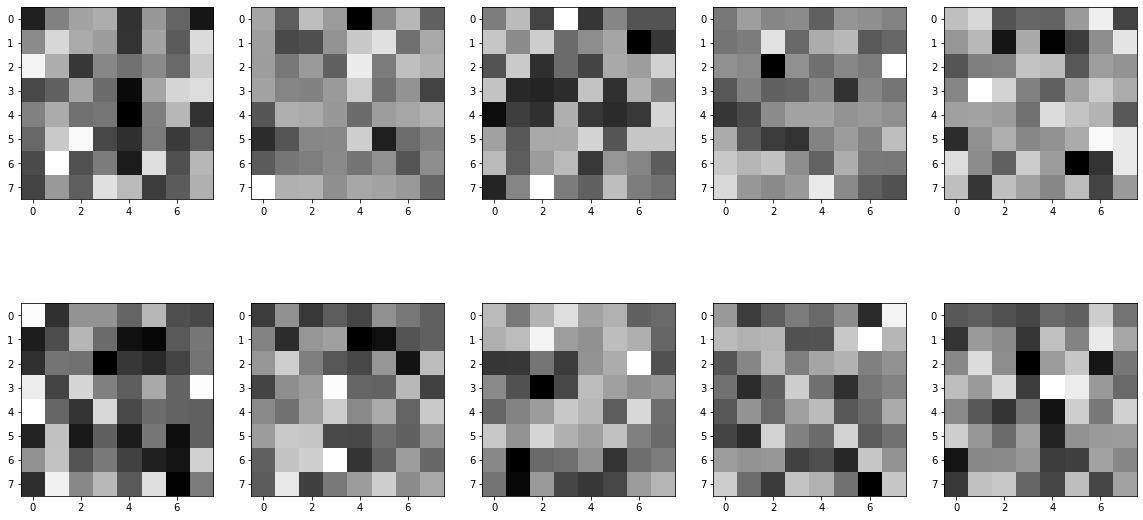

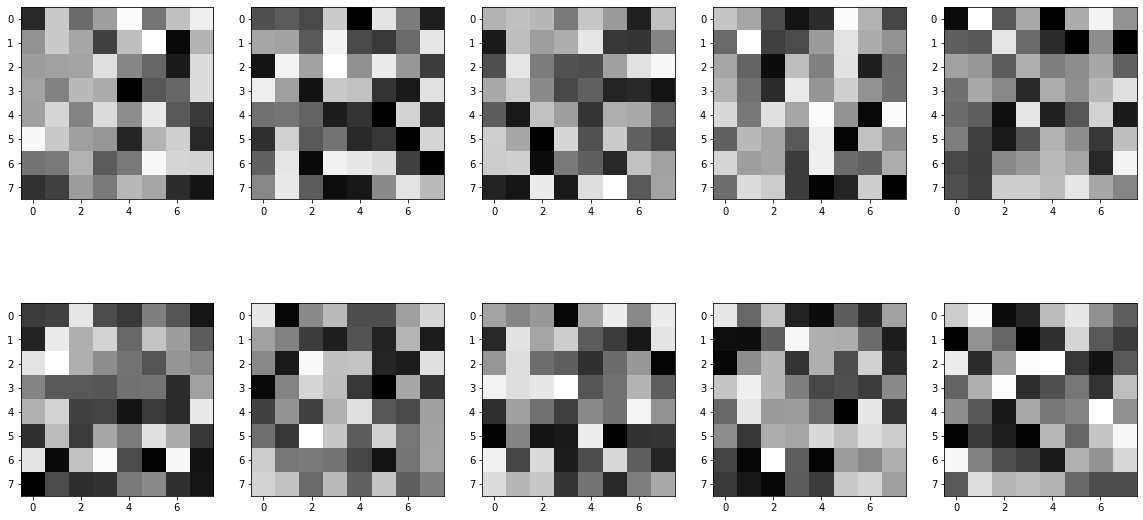

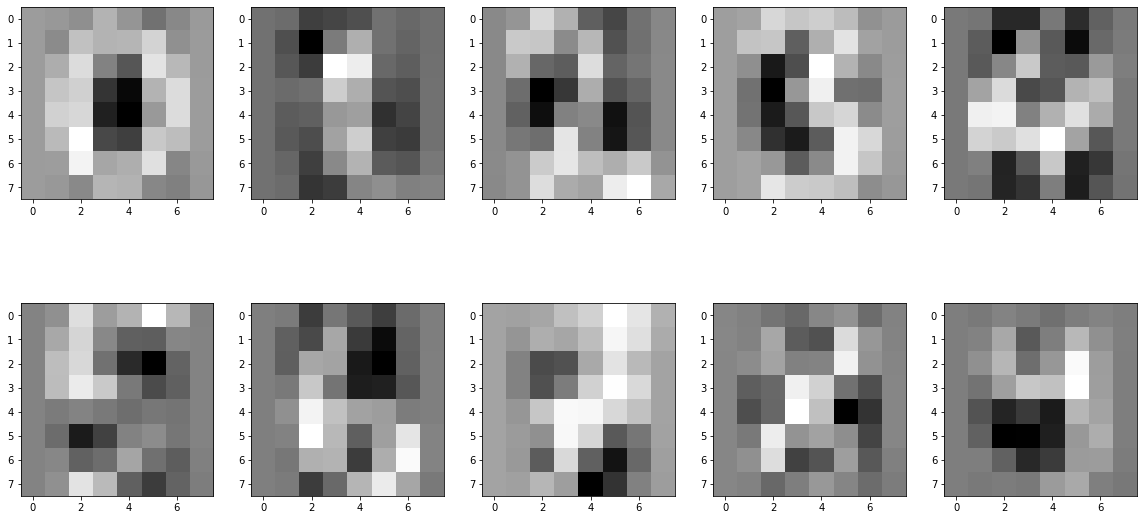

In [ ]:
for reg, lambda_i in zip([None, "l1", "l2"], [0, 0.5, 0.2]):
    NN = NaiveMNISTNetwork(features_amount=64, alpha_=0.05, reg_type=reg, lambda_=lambda_i)
    for i in range(1000):
        NN.fit(X_train_small, y_train_small)

    NN.print_weights()
    print(NN.score(X_test_small, y_test_small), NN.score(X_train_small, y_train_small))

Зависимость скорости обучения от величины шага

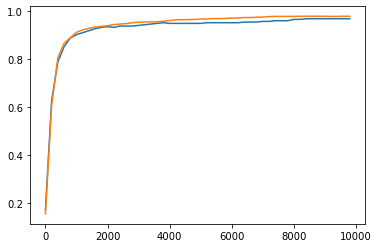

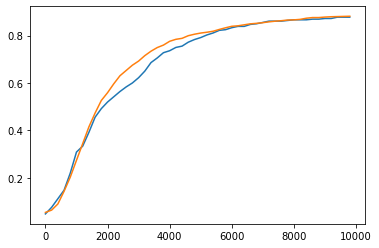

In [ ]:
for alpha in [0.1, 0.01]:
    NN = NaiveMNISTNetwork(64, alpha)
    y1, y2 = list(), list()
    for i in range(10000):
        if i % 200 == 0:
            y1.append(NN.score(X_test_small, y_test_small))
            y2.append(NN.score(X_train_small, y_train_small))
        NN.fit(X_train_small, y_train_small)

    plt.plot(range(0, 10000, 200), y1)
    plt.plot(range(0, 10000, 200), y2)
    plt.show()

Теперь загрузим более реальный набор данных размера $28 \times 28$. На вход будем подавать уже $784$ параметра

In [ ]:
(X_train_big, y_train_big), (X_test_big, y_test_big) = mnist.load_data()

X_train_big = X_train_big.reshape(-1, 784).astype("float32") / 255
X_test_big = X_test_big.reshape(-1, 784).astype("float32") / 255

0.093
0.2807
0.4357
0.536
0.5993
0.6415
0.6756
0.703
0.7216
0.7403


(0.7535, 0.7340833333333333)

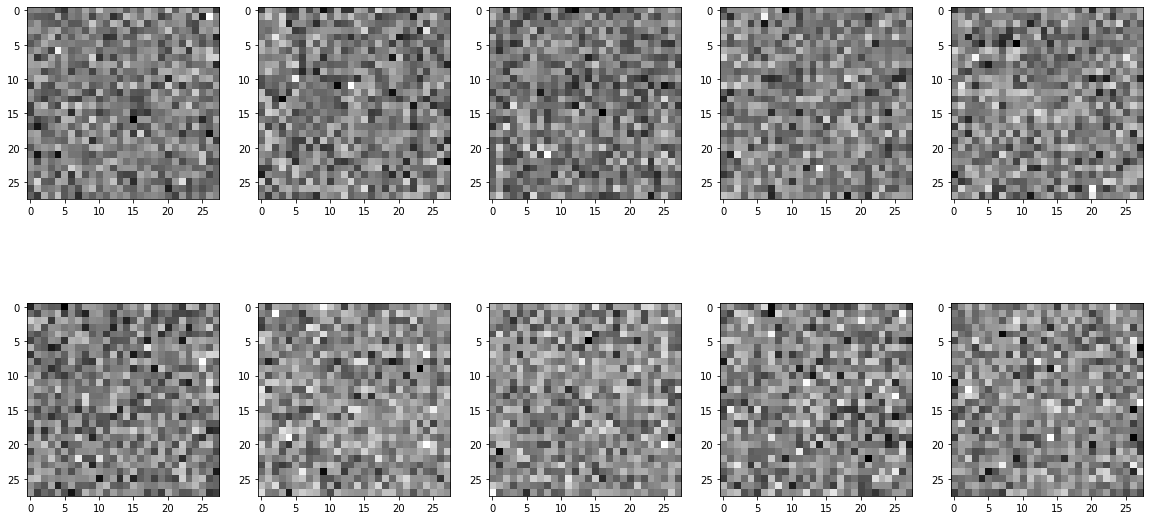

In [ ]:
NN = NaiveMNISTNetwork(features_amount=784, alpha_=0.05, lambda_=0.3)
for i in range(1000):
    if i % 100 == 0:
        print(NN.score(X_test_big, y_test_big))
    NN.fit(X_train_big, y_train_big)

NN.print_weights()
NN.score(X_test_big, y_test_big), NN.score(X_train_big, y_train_big)

0.8316 0.8214166666666667
CPU times: user 12min 51s, sys: 7min 10s, total: 20min 1s
Wall time: 2min 10s


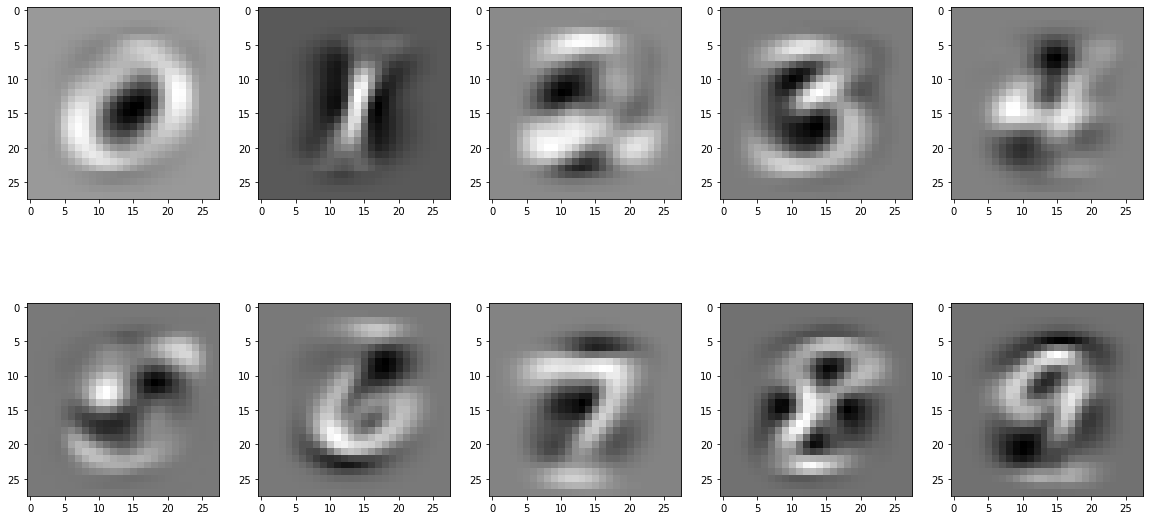

In [ ]:
%%time
NN = NaiveMNISTNetwork(features_amount=784, reg_type='l2', lambda_=0.2, alpha_=0.1, optimize_exp=True)
for i in range(1000):
    NN.fit(X_train_big, y_train_big)

NN.print_weights()
print(NN.score(X_test_big, y_test_big), NN.score(X_train_big, y_train_big))

0.8316 0.8214166666666667
CPU times: user 13min 17s, sys: 7min 10s, total: 20min 27s
Wall time: 2min 16s


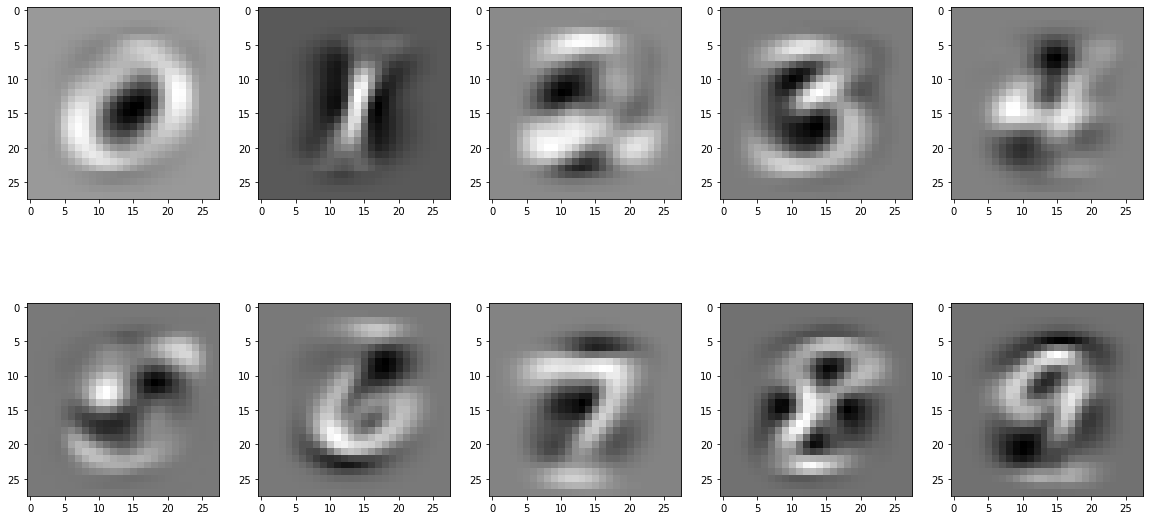

In [ ]:
%%time
NN = NaiveMNISTNetwork(features_amount=784, reg_type='l2', lambda_=0.2, alpha_=0.1, optimize_exp=False)
for i in range(1000):
    NN.fit(X_train_big, y_train_big)

NN.print_weights()
print(NN.score(X_test_big, y_test_big), NN.score(X_train_big, y_train_big))
